### Log(Kow) Analysis
- Created by: Louis Groff
- PIs: Imran Shah and Grace Patlewicz
- Last modified: 04 March 2024
- Changes made: Provide additional context from SI

Given the mixed recall rates observed, the correlation of simulator performance (i.e., recall rate) with the hydrophobicity (LogKow) of each chemical as an extension of the hierarchical clustering analysis of recall rate clustered on model and chemical class was performed. Given the functionality of the Toolbox API to return calculated physicochemical (physchem) properties for a chemical of interest, tthe Toolbox API was queried with the calculator GUID required to calculate log(Kow) (KOWWIN v1.69© 2015 U.S. Environmental Protection Agency) where available for each parent. The URL structure for the API call is as follows:
http://localhost:<port_number>/api/v6/calculation/<calculator_GUID>/<ChemID>
Toolbox API calculations successfully returned log(Kow) values for 99/112 parents. There were no clear log(Kow) clustering patterns within the chemical class groupings.

In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TOP = os.getcwd().replace("notebooks", "")
raw_dir = TOP + 'data/raw/'
processed_dir = TOP + 'data/processed/'
figures_dir = TOP + 'reports/figures/'
jcim = TOP + 'data/raw/JCIM_PhaseI/'
smpdb = TOP + 'data/raw/smpdb_drugs/'
missing = TOP + 'data/raw/extra_metsim/'

[Text(0.5, 0, '')]

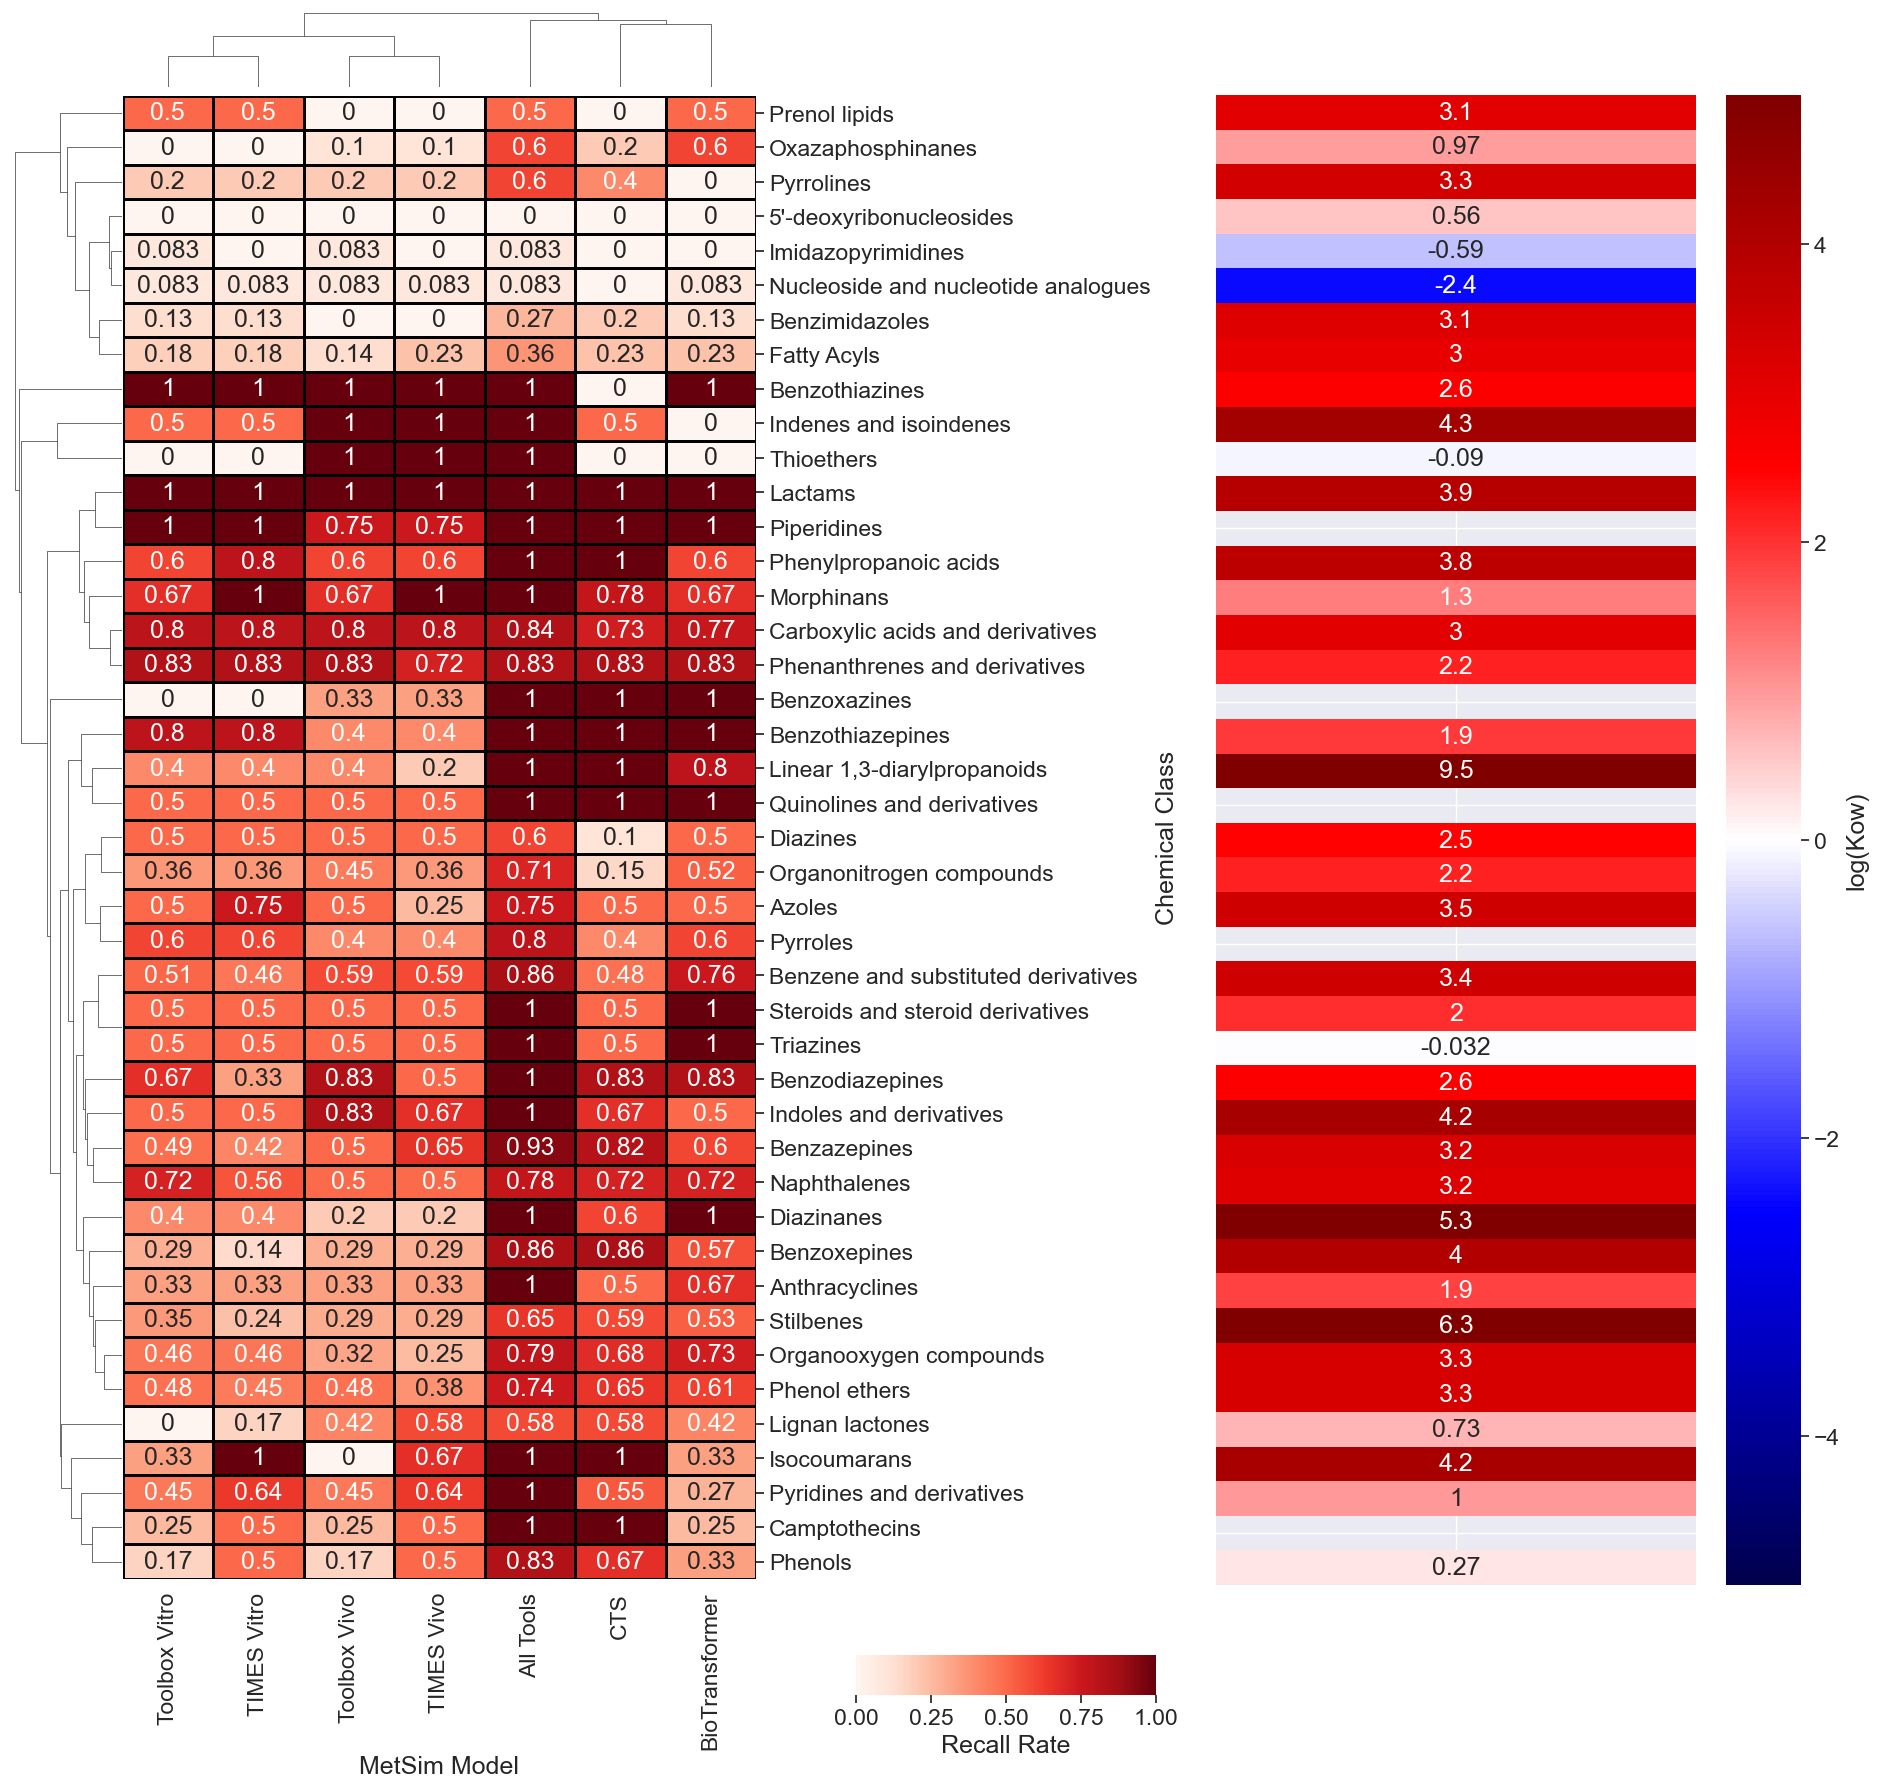

<Figure size 1000x2000 with 0 Axes>

In [3]:
tpr_df = pd.read_csv(processed_dir+'metsim_aggregate_smpdb_jcim_112parents.csv')
sns.set(font_scale=1.5)
drug_heatmap = sns.clustermap(tpr_df.loc[:,['chem_class','btrans_tpr','tb_s9_tpr','tb_vivo_tpr','times_s9_tpr','times_vivo_tpr','cts_tpr','aggregate_tpr']].groupby('chem_class').mean(),
                              linewidths=1, 
                              linecolor='black',
                              yticklabels=1,
                              cmap = 'Reds',
                              cbar_kws={'label': 'Recall Rate', 'orientation': 'horizontal'},
                              dendrogram_ratio=(0.15,0.05),
                              annot = True)
drug_heatmap.ax_heatmap.axes.set_xticklabels(['Toolbox Vitro', 'TIMES Vitro','Toolbox Vivo', 'TIMES Vivo', 'All Tools', 'CTS', 'BioTransformer'], rotation = 90)
drug_heatmap.ax_heatmap.set_ylabel('Chemical Class')
drug_heatmap.ax_heatmap.set_xlabel('MetSim Model')
drug_heatmap.fig.set_size_inches(20,20)
drug_heatmap.fig.subplots_adjust(right=0.4)
drug_heatmap.ax_cbar.set_position([0.45,0.13, 0.15,0.02])

sorted_yticks_drugs = drug_heatmap.ax_heatmap.axes.get_yticklabels()
sorted_yticks_drugs = [sorted_yticks_drugs[i].get_text() for i in range(len(sorted_yticks_drugs))]

clyf_unique = sorted_yticks_drugs
bars = drug_heatmap.fig.add_axes([0.63, 0.185, 0.3, 0.745])
grouped_df = tpr_df.groupby('chem_class').aggregate({'logkow': np.nanmean, 'consensus_tpr': np.nanmean})
plt.figure(figsize=(10,20))
# plt.clim([-10,10])
sns.heatmap(grouped_df.loc[sorted_yticks_drugs,['logkow']], 
            ax = bars,
            yticklabels=1, 
            annot = True,
            cmap='seismic',
            cbar_kws = {'label':'log(Kow)'},
            vmin=-5,
            vmax=5)
bars.set_yticklabels('')
bars.set_ylabel('')
bars.set_xticklabels('')
#drug_heatmap.savefig('C:\\Users\\LGROFF\\OneDrive - Environmental Protection Agency (EPA)\\Profile\\Documents\\Data\\GenRA\\BioTransformer3.0\\metsim_figs_figS6.png',facecolor='white',dpi=1200)


### Spearman Correlation Tests

Spearman correlation tests were performed across the 99 available individual parent chemicals with log(Kow) values (i.e., no ClassyFire grouping/averaging) in Python via the SciPy stats package, where the correlation coefficients calculated over the 99 ordered pairs of recall rate and log(Kow) are given for each simulator/model choice along with their associated p-values. Spearman correlation tests yielded p-values of < 0.05 for all models except for the two TIMES models, suggesting a statistically significant weak positive correlation between log(Kow) and observed recall rate for the remaining choices of simulator/model at a 95% confidence level. The correlation coefficients for the statistically significant results were 0.26 for BioTransformer (p = 0.009), 0.19 for Toolbox API In Vitro Rat Liver S9 (p = 0.004) and 0.20 for In Vivo Rat Simulator (p = 0.20), 0.31 for CTS (p = 0.002), and 0.27 for the aggregate of all models (0.006). While the correlation coefficients for the TIMES models fall in a similar range to the remaining models (In Vitro Rat Liver S9 = 0.19, In Vivo Rat Simulator = 0.15) their p-values are > 0.05 at 0.059 for the In Vitro Rat Liver S9 model, and 0.144 for the In Vivo Rat Simulator model. The weakness of the correlations calculated here between log(Kow) and recall rate do not provide a strong enough result to suggest that hydrophobicity of the parent and its effect on modeled enzymatic interactions is a major factor impacting the low-to-moderate recall rates observed using the current individual MetSim models.

In [4]:
#Spearman Correlations:
speartest_times_vivo = stats.spearmanr(tpr_df.loc[:,['times_vivo_tpr','logkow']].dropna())
speartest_times_s9 = stats.spearmanr(tpr_df.loc[:,['times_s9_tpr','logkow']].dropna())
speartest_tb_vivo = stats.spearmanr(tpr_df.loc[:,['tb_vivo_tpr','logkow']].dropna())
speartest_tb_s9 = stats.spearmanr(tpr_df.loc[:,['tb_s9_tpr','logkow']].dropna())
speartest_btrans =  stats.spearmanr(tpr_df.loc[:,['btrans_tpr','logkow']].dropna())
speartest_cts = stats.spearmanr(tpr_df.loc[:,['cts_tpr','logkow']].dropna())
speartest_aggregate = stats.spearmanr(tpr_df.loc[:,['aggregate_tpr','logkow']].dropna())

In [6]:
speartest_df = pd.DataFrame(columns=['tool','spearman_coeff','p_val'])
speartest_df['tool'] = ['TIMES_vivo','TIMES_S9','tb_api_vivo','tb_api_s9','biotransformer','cts','aggregate']
speartest_df['spearman_coeff'] = [speartest_times_vivo.correlation, speartest_times_s9.correlation, speartest_tb_vivo.correlation,speartest_tb_s9.correlation, speartest_btrans.correlation, speartest_cts.correlation, speartest_aggregate.correlation]
speartest_df['p_val'] = [speartest_times_vivo.pvalue, speartest_times_s9.pvalue, speartest_tb_vivo.pvalue, speartest_tb_s9.pvalue, speartest_btrans.pvalue, speartest_cts.pvalue, speartest_aggregate.pvalue]
speartest_df['spearman_coeff'] = round(speartest_df['spearman_coeff'],2)
speartest_df['p_val'] = round(speartest_df['p_val'],3)
speartest_df.to_csv(processed_dir+'metsim_table_s6.csv')
speartest_df

,tool,spearman_coeff,p_val
0,TIMES_vivo,0.15,0.144
1,TIMES_S9,0.19,0.059
2,tb_api_vivo,0.20,0.044
3,tb_api_s9,0.29,0.004
4,biotransformer,0.26,0.009
5,cts,0.31,0.002
6,aggregate,0.27,0.006
